<a href="https://colab.research.google.com/github/firstheo/co-deep-learning-/blob/before_master/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터 분할을 위한 폴더 생성

In [1]:
import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
original_dataset_dir = '/content/drive/MyDrive/pytorch/dataset'
classes_list = os.listdir(original_dataset_dir)

In [4]:
base_dir = '/content/drive/MyDrive/pytorch/splitted'
os.mkdir(base_dir)

In [5]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'val')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [6]:
for clss in classes_list:
  os.mkdir(os.path.join(train_dir, clss))
  os.mkdir(os.path.join(validation_dir, clss))
  os.mkdir(os.path.join(test_dir, clss))

데이터 분할과 클래스별 데이터 수 확인

In [7]:
import math

for clss in classes_list:
  path = os.path.join(original_dataset_dir, clss)
  fnames = os.listdir(path)

  train_size = math.floor(len(fnames) * 0.6)
  validation_size = math.floor(len(fnames) * 0.2)
  test_size = math.floor(len(fnames) * 0.2)

  train_fnames = fnames[:train_size]
  print('Train size(',clss,'): ', len(train_fnames))
  for fname in train_fnames:
    src = os.path.join(path, fname)
    dst = os.path.join(os.path.join(train_dir, clss), fname)
    shutil.copyfile(src, dst)

  validation_fnames = fnames[train_size:(validation_size + train_size)]
  print('Validation size(',clss,'): ', len(validation_fnames))
  for fname in validation_fnames:
    src = os.path.join(path, fname)
    dst = os.path.join(os.path.join(validation_dir, clss), fname)
    shutil.copyfile(src, dst)

  test_fnames = fnames[(train_size + validation_size):(validation_size + train_size + test_size)]

  print('Test size(',clss,'): ', len(test_fnames))
  for fname in test_fnames:
    src = os.path.join(path, fname)
    dst = os.path.join(os.path.join(test_dir, clss), fname)
    shutil.copyfile(src, dst)



Train size( normal_up ):  44
Validation size( normal_up ):  14
Test size( normal_up ):  14
Train size( abnormal_up ):  30
Validation size( abnormal_up ):  10
Test size( abnormal_up ):  10
Train size( normal_down ):  29
Validation size( normal_down ):  9
Test size( normal_down ):  9
Train size( abnormal_down ):  21
Validation size( abnormal_down ):  7
Test size( abnormal_down ):  7


베이스라인 모델학습을 위한 준비

In [8]:
import torch

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

BATCH_SIZE = 256
EPOCH = 30
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

train_dataset = ImageFolder(root='/content/drive/MyDrive/pytorch/splitted/train', transform=transform_base)
val_dataset = ImageFolder(root='/content/drive/MyDrive/pytorch/splitted/val', transform=transform_base)

from torch.utils.data import DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


베이스라인 모델 설계



In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

    self.fc1 = nn.Linear(4096, 512)
    self.fc2 = nn.Linear(512, 33)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training)

    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training)

    x = x.view(-1, 4096)
    x = self.fc1(x)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)

model_base = Net().to(DEVICE)
optimizer = optim.Adam(model_base.parameters(), lr=0.001)



모델 학습을 위한 함수

In [10]:
def train(model, train_loader, optimizer):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()

모델 평가를 위한 함수

In [11]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = model(data)

      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

모델 학습 실행하기

In [12]:
import time
import copy

def train_baseline(model, train_loader, val_loader, optimizer, num_epochs = 30):
  best_acc = 0.0
  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(1, num_epochs + 1):
    since = time.time()
    train(model, train_loader, optimizer)
    train_loss, train_acc = evaluate(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('-------------- epoch {} ----------------'.format(epoch))

    print('train Loss: {:.4f}, Accuracy: {:.2f}%' .format(train_loss, train_acc))

    print('val Loss: {:.4f}, Accuracy: {:.2f}%' .format(val_loss, val_acc))

    print('Completed in {:.0f}m {:.0f}s' .format(time_elapsed // 60, time_elapsed % 60))

  model.load_state_dict(best_model_wts)
  return model

base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)

torch.save(base,'baseline.pt')



-------------- epoch 1 ----------------
train Loss: 3.0990, Accuracy: 41.13%
val Loss: 3.1021, Accuracy: 37.50%
Completed in 0m 9s
-------------- epoch 2 ----------------
train Loss: 2.1741, Accuracy: 40.32%
val Loss: 2.1823, Accuracy: 42.50%
Completed in 0m 7s
-------------- epoch 3 ----------------
train Loss: 1.1587, Accuracy: 56.45%
val Loss: 1.1785, Accuracy: 55.00%
Completed in 0m 6s
-------------- epoch 4 ----------------
train Loss: 0.9582, Accuracy: 45.16%
val Loss: 1.0033, Accuracy: 45.00%
Completed in 0m 7s
-------------- epoch 5 ----------------
train Loss: 0.7317, Accuracy: 63.71%
val Loss: 0.7621, Accuracy: 57.50%
Completed in 0m 6s
-------------- epoch 6 ----------------
train Loss: 0.5881, Accuracy: 67.74%
val Loss: 0.6454, Accuracy: 65.00%
Completed in 0m 7s
-------------- epoch 7 ----------------
train Loss: 0.5187, Accuracy: 75.81%
val Loss: 0.6574, Accuracy: 60.00%
Completed in 0m 6s
-------------- epoch 8 ----------------
train Loss: 0.4518, Accuracy: 96.77%
val Lo

Transfer Learning을 위한 준비

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([64,64]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop(52),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([64,64]),
        transforms.RandomCrop(52),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = '/content/drive/MyDrive/pytorch/splitted'
image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes


Pre-Trained Model 불러오기

In [14]:
from torchvision import models

resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 33)
resnet = resnet.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)

from torch.optim import lr_scheduler

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 279MB/s]


Pre-Trained Model의 일부 Layer Freeze하기

In [15]:
ct = 0
for child in resnet.children():
  ct += 1
  if ct < 6:
    for param in child.parameters():
      param.requires_grad = False

Transfer Learning 모델 학습과 검증을 위한 함수

In [16]:
def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('-------------epoch {}-------------'.format(epoch+1))
    since = time.time()

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()
        l_r = [x['lr'] for x in optimizer_ft.param_groups]
        print('learning rate: ',l_r)

      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}' .format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Completed in {:.0f}m {:.0f}s' .format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)

  return model



모델 학습 실행하기

In [17]:
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)

torch.save(model_resnet50, 'resnet50.pt')

-------------epoch 1-------------
learning rate:  [0.001]
train Loss: 3.6705 Acc: 0.0161
val Loss: 1.3231 Acc: 0.6750
Completed in 0m 11s
-------------epoch 2-------------
learning rate:  [0.001]
train Loss: 1.0902 Acc: 0.7258
val Loss: 1.1976 Acc: 0.7500
Completed in 0m 11s
-------------epoch 3-------------
learning rate:  [0.001]
train Loss: 0.4114 Acc: 0.8952
val Loss: 2.1793 Acc: 0.7000
Completed in 0m 21s
-------------epoch 4-------------
learning rate:  [0.001]
train Loss: 0.3781 Acc: 0.8952
val Loss: 3.5386 Acc: 0.7750
Completed in 0m 12s
-------------epoch 5-------------
learning rate:  [0.001]
train Loss: 0.1522 Acc: 0.9516
val Loss: 2.0650 Acc: 0.8250
Completed in 0m 11s
-------------epoch 6-------------
learning rate:  [0.001]
train Loss: 0.0173 Acc: 1.0000
val Loss: 1.1346 Acc: 0.8500
Completed in 0m 11s
-------------epoch 7-------------
learning rate:  [0.0001]
train Loss: 0.0232 Acc: 1.0000
val Loss: 0.8375 Acc: 0.8500
Completed in 0m 10s
-------------epoch 8-------------

베이스라인 모델 평가를 위한 전처리

In [18]:
transform_base = transforms.Compose([transforms.Resize([64,64]), transforms.ToTensor()])

test_base = ImageFolder(root='/content/drive/MyDrive/pytorch/splitted/test', transform=transform_base)

test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

Transfer Learning모델 평가를 위한 전처리

In [19]:
transform_resNet = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.RandomCrop(52),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

test_resNet = ImageFolder(root='/content/drive/MyDrive/pytorch/splitted/test', transform=transform_resNet)

test_loader_resNet = torch.utils.data.DataLoader(test_resNet, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

베이스라인 모델 성능 평가하기

In [20]:
baseline=torch.load('baseline.pt')
baseline.eval()
test_loss, test_accuracy = evaluate(baseline, test_loader_base)

print('baseline test acc: ', test_accuracy)

baseline test acc:  87.5


Transfer Learning 모델 성능 평가하기

In [21]:
resnet50=torch.load('resnet50.pt')
resnet50.eval()
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)

print('ResNet test acc: ', test_accuracy)

ResNet test acc:  100.0


In [ ]:
from PIL import Image
import glob

# 이미지 경로를 입력받아 가장 비슷한 클래스를 출력하는 함수
def predict_image_class(image_path, model):
    transform = transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_image)
        _, predicted_idx = torch.max(output, 1)

    # 클래스 라벨
    classes = ['abnormal_down', 'abnormal_up', 'normal_down', 'normal_up']

    # 결과 출력
    print("Predicted class: {}".format(classes[predicted_idx.item()]))
    print("Confidence: {:.2f}%".format(F.softmax(output, dim=1)[0][predicted_idx.item()] * 100))

image_paths = []

# 폴더 내의 모든 이미지 파일들을 가져와서 리스트에 추가
folder_path = '/content/drive/MyDrive/new_photo/'
image_paths.extend(glob.glob(folder_path + '*.png'))

# 파일 이름을 기준으로 정렬
image_paths.sort()

# 'base' 모델로 이미지 분류 결과 출력
#for image_path in image_paths:
    #print("Image form base:", image_path)
    #predict_image_class(image_path, base)
    #print()

# 'resnet50' 모델로 이미지 분류 결과 출력
for image_path in image_paths:
    print("Image from resnet:", image_path)
    predict_image_class(image_path, resnet50)
    print()


In [ ]:
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import glob
import os

# 이미지 경로를 입력받아 가장 비슷한 클래스를 출력하는 함수
def predict_image_class(image_path, model):
    transform = transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_image)
        _, predicted_idx = torch.max(output, 1)

    # 클래스 라벨
    classes = ['abnormal_down', 'abnormal_up', 'normal_down', 'normal_up']

    # 결과 출력
    print("Predicted class: {}".format(classes[predicted_idx.item()]))
    print("Confidence: {:.2f}%".format(F.softmax(output, dim=1)[0][predicted_idx.item()] * 100))

    return classes[predicted_idx.item()]

# GPU 사용 여부 확인
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

# 학습된 모델 로드
model_resnet50 = torch.load('resnet50.pt')
model_resnet50.eval()

# 이미지 파일 경로들을 저장할 리스트
image_paths = []

# 폴더 내의 모든 이미지 파일들을 가져와서 리스트에 추가
folder_path = '/content/drive/MyDrive/new_photo/'
image_paths = glob.glob(folder_path + '*.png')

# 파일 이름을 기준으로 정렬
image_paths.sort()

# 클래스 라벨
classes = ['abnormal_down', 'abnormal_up', 'normal_down', 'normal_up']

# 이미지를 저장할 폴더의 기본 경로
save_folder_path = '/content/drive/MyDrive/pytorch/complete/'

# 'resnet50' 모델로 이미지 분류 결과 출력
for image_path in image_paths:
    print("Image from resnet:", image_path)
    predicted_class = predict_image_class(image_path, model_resnet50)

    # 해당 클래스의 폴더 경로
    class_folder_path = os.path.join(save_folder_path, predicted_class)

    # 폴더가 존재하지 않을 경우 생성
    if not os.path.exists(class_folder_path):
        os.makedirs(class_folder_path)

    # 이미지 저장
    image = Image.open(image_path).convert('RGB')
    image.save(os.path.join(class_folder_path, os.path.basename(image_path)))
    print("Image saved to:", class_folder_path)
    print()


그래프 출력

-------------epoch 1-------------
learning rate:  [1.0000000000000002e-07]
train Loss: 0.0327 Acc: 0.9919
val Loss: 0.0020 Acc: 1.0000
Completed in 0m 11s
-------------epoch 2-------------
learning rate:  [1.0000000000000002e-07]
train Loss: 0.0061 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000
Completed in 0m 11s
-------------epoch 3-------------
learning rate:  [1.0000000000000002e-07]
train Loss: 0.0056 Acc: 1.0000
val Loss: 0.0004 Acc: 1.0000
Completed in 0m 11s
-------------epoch 4-------------
learning rate:  [1.0000000000000002e-07]
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000
Completed in 0m 10s
-------------epoch 5-------------
learning rate:  [1.0000000000000004e-08]
train Loss: 0.0050 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000
Completed in 0m 11s
-------------epoch 6-------------
learning rate:  [1.0000000000000004e-08]
train Loss: 0.0222 Acc: 0.9919
val Loss: 0.0005 Acc: 1.0000
Completed in 0m 11s
-------------epoch 7-------------
learning rate:  [1.0000000000000004e

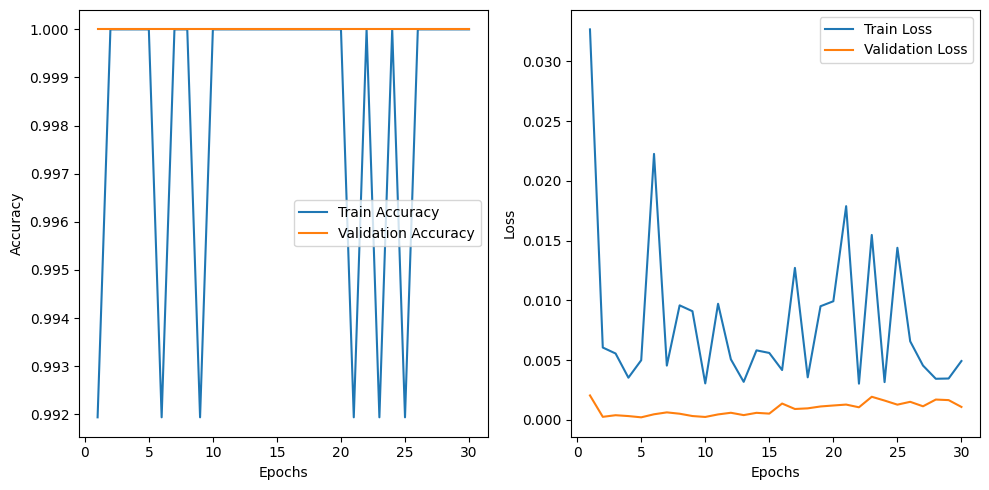

In [23]:
import matplotlib.pyplot as plt

# Function to train the model and record accuracy and loss at each epoch
def train_resnet_with_metrics(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store accuracy and loss values
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        print('-------------epoch {}-------------'.format(epoch+1))
        since = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
                l_r = [x['lr'] for x in optimizer_ft.param_groups]
                print('learning rate: ', l_r)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc)
                train_loss_list.append(epoch_loss)
            else:
                val_acc_list.append(epoch_acc)
                val_loss_list.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # Plot accuracy and loss graphs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    model.load_state_dict(best_model_wts)

    return model

# Call the updated training function
model_resnet50 = train_resnet_with_metrics(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)

# Save the trained model
torch.save(model_resnet50, 'resnet50.pt')
